## Geographical Vector Rotation

Routines to rotate fields of 2D vectors from a geographical CRS to another. Makes heavy use of pyproj.

**NB** This is experimental code which has not been fully controlled. Use with care and report bugs. 

In [1]:
import numpy as np
import xarray as xr
import pyresample as pr
import pyproj

from matplotlib import pylab as plt

## Routines for vector rotation

In [2]:
def get_rotation_unit_vectors(x_from, y_from, crs_from, crs_to):
    """Compute two sets of unit vectors (ux and uy) defining the x and y axes of the rotation.
    
    Args:
       x_from (2D array): x locations of the grid in the 'from' crs
       y_from (2D array): y locations of the grid in the 'from' crs
       crs_from (pyproj.CRS): pyproj object defining the 'from' crs
       crs_to (pyproj.CRS): pyproj object defining the 'to' crs
       
    Returns:
       ux (3D array): x and y components of the ux unit vector of the rotation in the 'from' crs.
       vx (3D array): x and y components of the uy unit vector of the rotation in the 'from' crs.
    
    Notes:
       -  this step is a pre-processing before the actual rotation of the vectors. The vectors to be
          rotated are not input parameters to the routine.
       -  x_from and y_from must be in units that can directly be entered the 'from' crs (e.g. meters
          or degrees) as no unit conversion is performed inside this routine.
    """
    # sanity check on the shape of the input parameters
    if x_from.shape != y_from.shape:
        raise ValueError("x_from and y_from must have the same shape.")
    if len(x_from.shape) != 2:
        raise ValueError("x_from and y_from must be 2D arrays.")
    
    # define the transform from one crs to the other
    transformer = pyproj.Transformer.from_crs(crs_from, crs_to)
    
    # transform x_from, y_from from the "from" crs to the "to" crs.
    x_to, y_to = transformer.transform(x_from, y_from)
    
    # in the "to" crs, compute a small increasing step in 'x' direction.
    #   its length does not matter, we will normalize to unit vectors later
    epsx_to = 0.1
    x2_to = x_to + epsx_to
    
    # if the "to" crs is geographic, then x is the longitude and we must wrap x2 to [-180;+180]
    if crs_to.is_geographic:
        x2_to = (x2_to + 180) % 360 - 180
        
    # transform the x_to + epsx_to (ux direction) back into the "from" crs
    x_ux_from, y_ux_from = transformer.transform(x2_to, y_to,
                    direction=pyproj.enums.TransformDirection.INVERSE)
    
    # define the ux vectors in the "from" crs
    ux = np.stack(((x_ux_from - x_from),(y_ux_from - y_from)), axis=2)
    
    # normalize each vector to be unit vectors
    ux_norm = (ux[:,:,0]**2 + ux[:,:,1]**2)**0.5
    ux /= np.repeat(ux_norm[:,:,None], 2, axis=2)
    
    # define uy which is perpendicular to ux
    uy = ux.copy()
    uy[:,:,0] = -ux[:,:,1]
    uy[:,:,1] = +ux[:,:,0]
    
    # done, return
    return ux, uy

def apply_vector_rotation(vec_x, vec_y, ux, uy):
    """Rotate 2D vector fields (vec_x, vec_y) onto axes defined by unit vectors ux and uy
    
    Args:
       vec_x (2D array): x components of the vectors to be rotated
       vec_y (2D array): y components of the vectors to be rotated
       ux (2D array) : unit vector defining the x-direction of the rotation
       uy (2D array) : unit vector defining the y-direction of the rotation
       
    Returns:
       rot_x (2D array): x components of the rotated vectors.
       rot_y (2D array): y components of the rotated vectors.
    
    """
    # sanity check on the shape of the input parameters
    if vec_x.shape != vec_y.shape:
        raise ValueError("vec_x and vec_y must have the same shape.")
    if len(vec_x.shape) != 2:
        raise ValueError("vec_x and vec_y must be 2D arrays.")
    
    # prepare an (nx,ny,2) array for the input (vec_x,vec_y) vector
    vec = np.stack((vec_x,vec_y), axis=2)
    
    # use the einsum notation to compute dot products at each (nx,ny) locations
    rot_x = np.einsum('ijk,ijk->ij',vec,ux)
    rot_y = np.einsum('ijk,ijk->ij',vec,uy)
    
    # done, return
    return rot_x, rot_y



## Plotting routines

In [3]:
import cartopy

def plot_rotation_unit_vectors(x_from, y_from, ux, uy, ccrs_from, ccrs_to, ev=5):
    """Plot two views of the unit vectors. First in the 'to' crs, then in the 'from' crs."""
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=ccrs_to))
    ax.coastlines()
    ax.quiver(x_from[::ev,::ev], y_from[::ev,::ev], ux[::ev,::ev,0], ux[::ev,::ev,1],
          angles='xy', label='ux', color='C0', transform=ccrs_from)
    ax.quiver(x_from[::ev,::ev], y_from[::ev,::ev], uy[::ev,::ev,0], uy[::ev,::ev,1],
          angles='xy', label='uy', color='C1', transform=ccrs_from)
    ax.legend()
    ax.set_title("Rotation unit vectors in the 'to' crs")
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=ccrs_from))
    ax.coastlines()
    ax.quiver(x_from[::ev,::ev], y_from[::ev,::ev], ux[::ev,::ev,0], ux[::ev,::ev,1],
          angles='xy', label='ux', color='C0')
    ax.quiver(x_from[::ev,::ev], y_from[::ev,::ev], uy[::ev,::ev,0], uy[::ev,::ev,1],
          angles='xy', label='uy', color='C1')
    ax.legend()
    ax.set_title("Rotation unit vectors in the 'from' crs")
    plt.show()
    
def plot_vector_components(vec_x, vec_y, rot_x, rot_y, ccrs_from):
    """Plot maps of the x and y components before and after rotation."""
    import cmocean
    cmap = cmocean.cm.balance
    vmin,vmax = np.percentile(np.ma.masked_invalid(vec_x).compressed(),(1,99))
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,9), sharex=True, sharey=True,
                           subplot_kw=dict(projection=ccrs_from))
    ax[0,0].coastlines()
    ax[0,0].imshow(vec_x,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0,0].set_title('original X component')
    ax[0,1].coastlines()
    ax[0,1].imshow(vec_y,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[0,1].set_title('original Y component')

    ax[1,0].coastlines()
    ax[1,0].imshow(rot_x,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1,0].set_title('rotated X component')
    ax[1,1].coastlines()
    ax[1,1].imshow(rot_y,transform=ccrs_from, extent=ccrs_from.bounds, origin='upper',
               cmap=cmap, vmin=vmin, vmax=vmax)
    ax[1,1].set_title('rotated Y component')
    plt.show()
    
def plot_vectors(x_from, y_from, vec_x, vec_y, rot_x, rot_y, crs_from, crs_to, ccrs_from, ccrs_to, ev=2):
    """Plot vectors before and after rotation."""
    # Plot the vectors before rotation and in the 'from' crs.
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=ccrs_from))
    ax.coastlines()
    ax.quiver(x_from[::ev,::ev], y_from[::ev,::ev], vec_x[::ev,::ev], vec_y[::ev,::ev],
              angles='xy', scale_units='xy', scale=0.1)
    ax.set_title("Vectors before rotation in the 'from' crs")
    plt.show()
    
    # define the transform from one crs to the other
    transformer = pyproj.Transformer.from_crs(crs_from, crs_to)
    
    # transform x_from, y_from from the "from" crs to the "to" crs.
    x_to, y_to = transformer.transform(x_from, y_from)
    
    # Plot the vectors after rotation in the 'to' crs
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=ccrs_to))
    ax.coastlines()
    ax.quiver(x_to[::ev,::ev], y_to[::ev,::ev], rot_x[::ev,::ev], rot_y[::ev,::ev],
              angles='xy', scale_units='xy', scale=0.1)
    ax.set_title("Vectors after rotation in the 'to' crs")
    plt.show()
    

### Demonstrations

#### Demo 1: from EASE2 to latlon

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another 

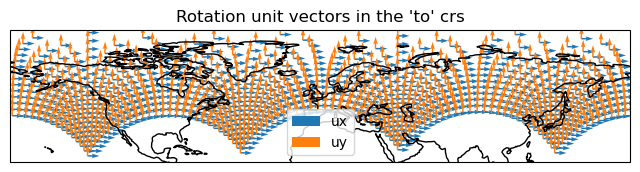

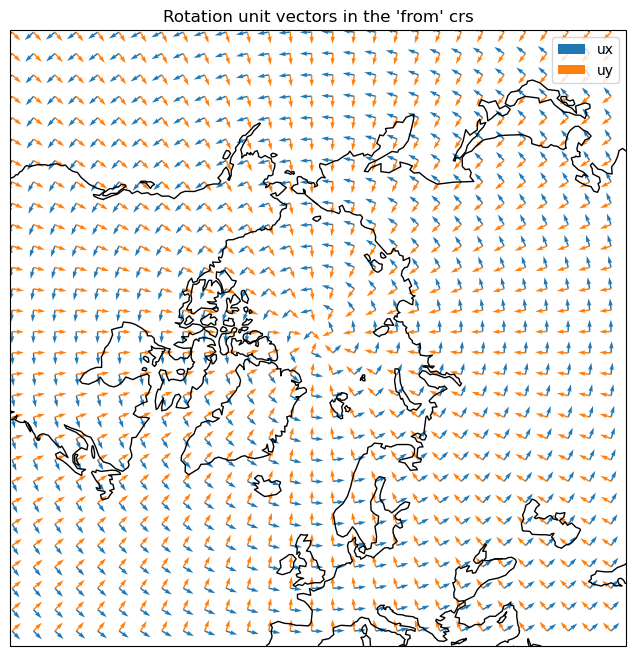

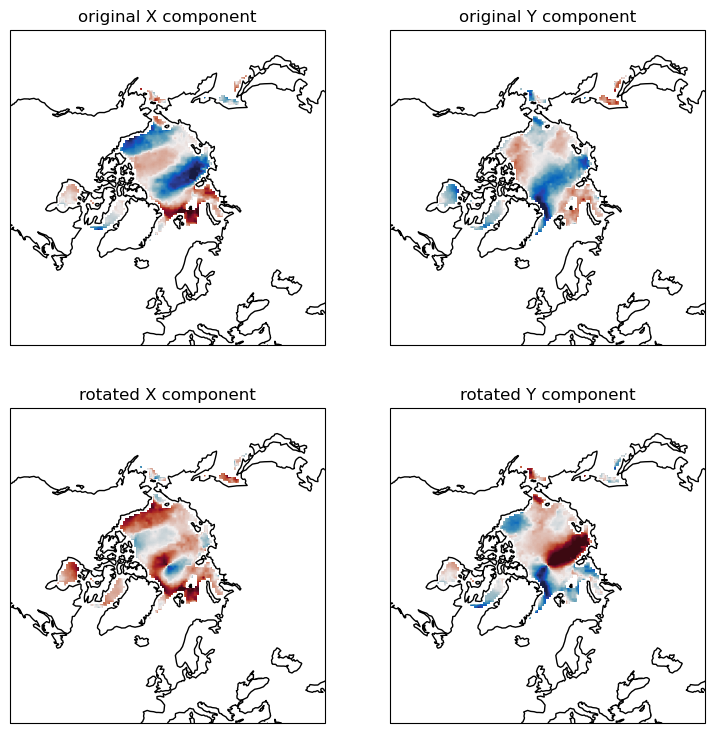

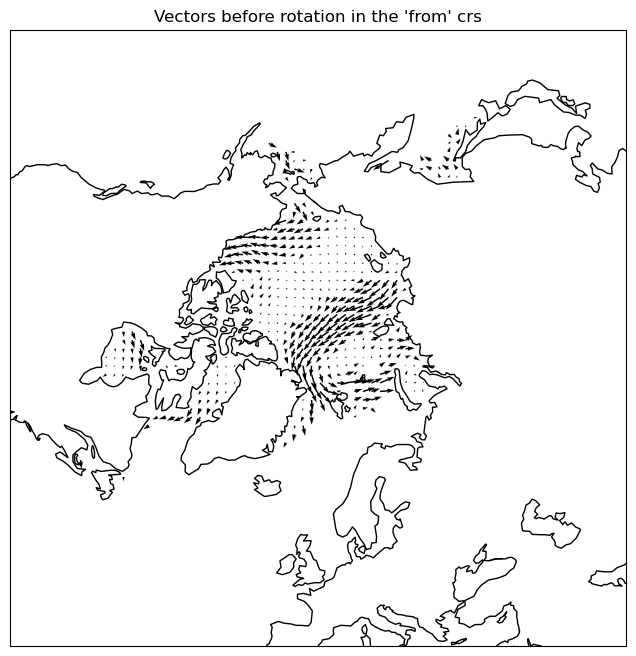

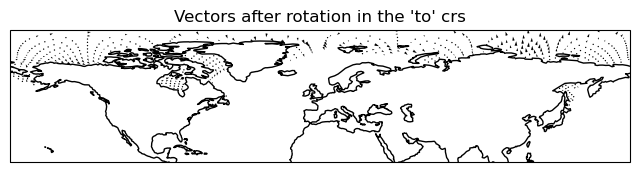

In [4]:
# the OSI SAF sea-ice drift CDR v1 is on EASE2 polar grids
f = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2020/03/ice_drift_nh_ease2-750_cdr-v1p0_24h-202003151200.nc'
ds = xr.open_dataset(f)
adef, _ = pr.utils.load_cf_area(ds)
crs_from = adef.crs
x_from, y_from = np.meshgrid(adef.projection_x_coords, adef.projection_y_coords)
ccrs_from = adef.to_cartopy_crs()
vec_x = ds['dX'][0].data * 1000.
vec_y = ds['dY'][0].data * 1000.

# define target crs: a Plate Carree (WGS84) (lat/lon)
crs_to_epsg = '32663'
crs_to = pyproj.CRS(crs_to_epsg)
ccrs_to = cartopy.crs.epsg(crs_to_epsg)

# rotate vector components
ux, uy = get_rotation_unit_vectors(x_from, y_from, crs_from, crs_to)
rot_x, rot_y = apply_vector_rotation(vec_x, vec_y, ux, uy)

# plot
plot_rotation_unit_vectors(x_from, y_from, ux, uy, ccrs_from, ccrs_to)
plot_vector_components(vec_x, vec_y, rot_x, rot_y, ccrs_from)
plot_vectors(x_from, y_from, vec_x, vec_y, rot_x, rot_y, crs_from, crs_to, ccrs_from, ccrs_to,)

#### Demo 2: from EASE2 to a polar stereographic grid

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another 

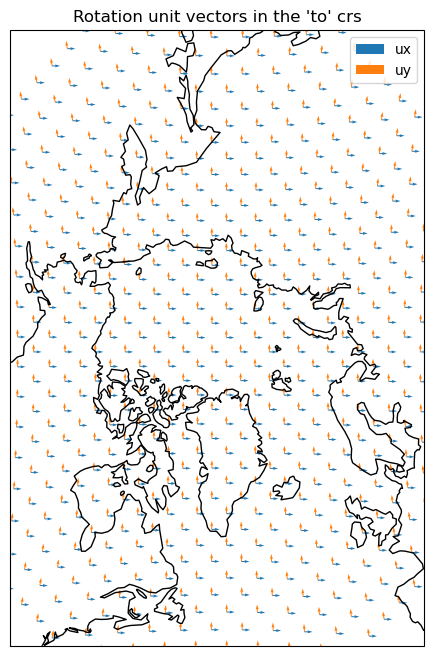

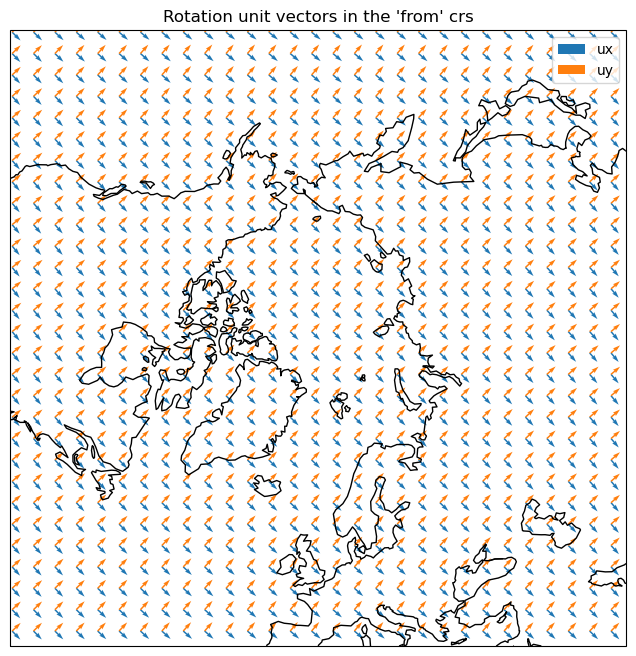

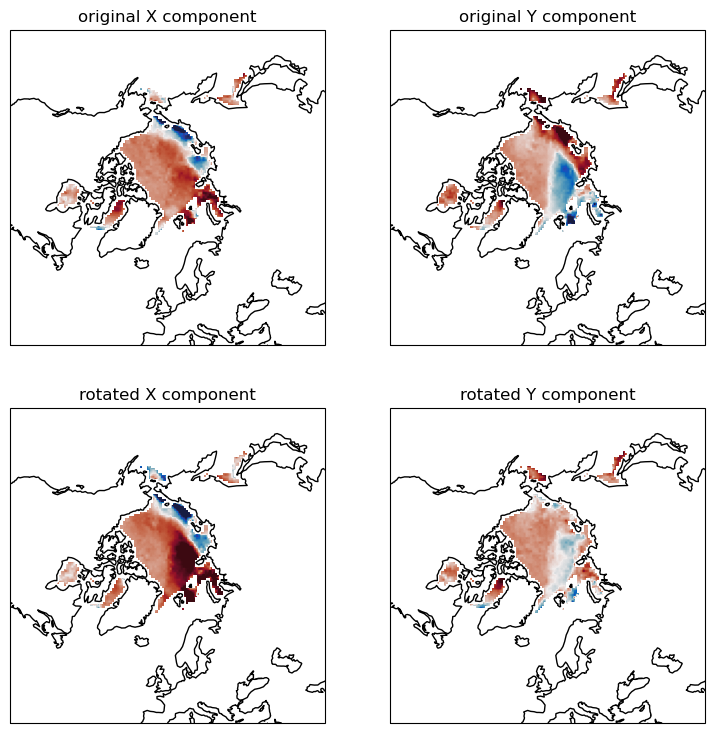

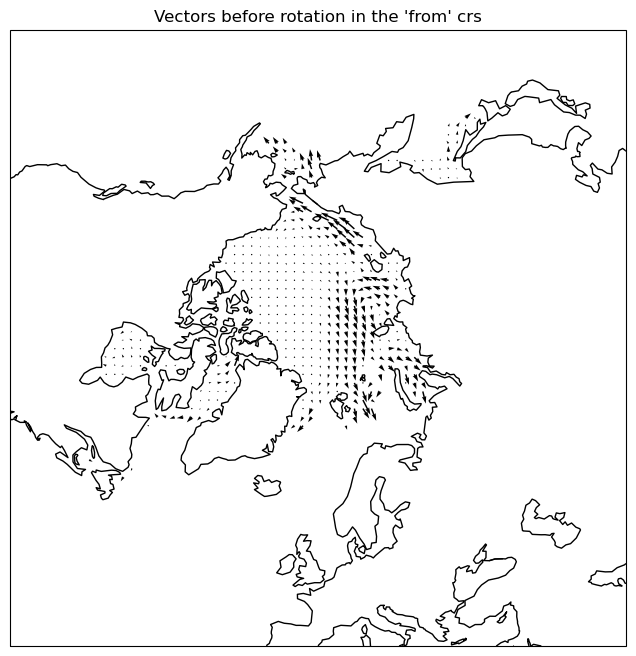

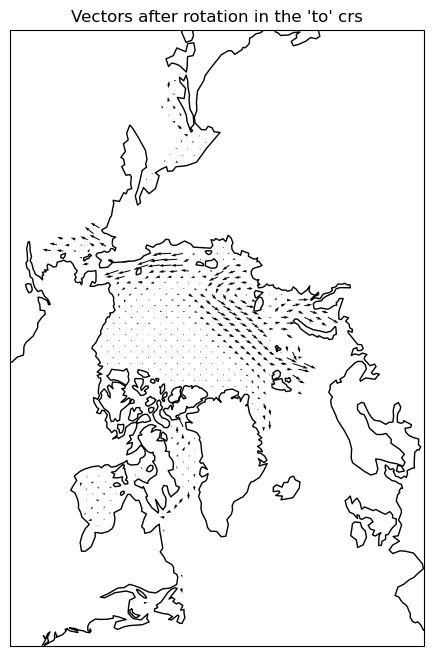

In [5]:
# the OSI SAF sea-ice drift CDR v1 is on EASE2 polar grids
f = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/drift_455m_files/merged/2020/03/ice_drift_nh_ease2-750_cdr-v1p0_24h-202003031200.nc'
ds = xr.open_dataset(f)
adef, _ = pr.utils.load_cf_area(ds)
crs_from = adef.crs
x_from, y_from = np.meshgrid(adef.projection_x_coords, adef.projection_y_coords)
ccrs_from = adef.to_cartopy_crs()
vec_x = ds['dX'][0].data * 1000.
vec_y = ds['dY'][0].data * 1000.

# define target crs, that of an OSI SAF sea-ice drift Near Real Time file
f2 = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/drift_lr/merged/2020/03/ice_drift_nh_polstere-625_multi-oi_202003101200-202003121200.nc'
adef2, _ = pr.utils.load_cf_area(f2)
crs_to = adef2.crs
ccrs_to = adef2.to_cartopy_crs()

# rotate vector components
ux, uy = get_rotation_unit_vectors(x_from, y_from, crs_from, crs_to)
rot_x, rot_y = apply_vector_rotation(vec_x, vec_y, ux, uy)

# plot
plot_rotation_unit_vectors(x_from, y_from, ux, uy, ccrs_from, ccrs_to)
plot_vector_components(vec_x, vec_y, rot_x, rot_y, ccrs_from)
plot_vectors(x_from, y_from, vec_x, vec_y, rot_x, rot_y, crs_from, crs_to, ccrs_from, ccrs_to,)

#### Demo 3: from polar stereographic to a rotated lat/lon grid

/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/thomasl/mambaforge/envs/py310/lib/python3.10/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-r

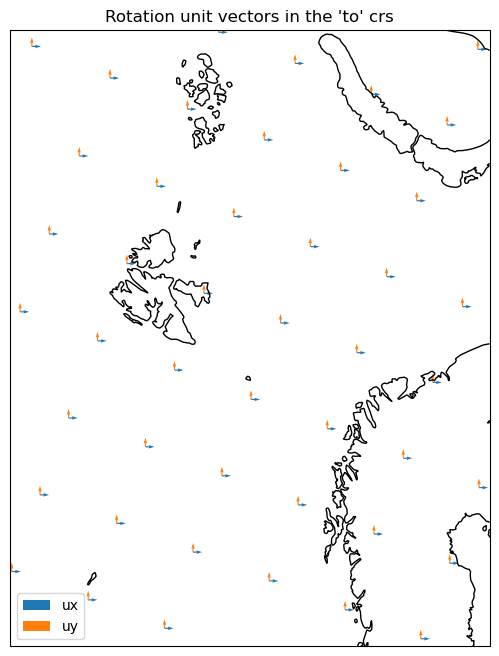

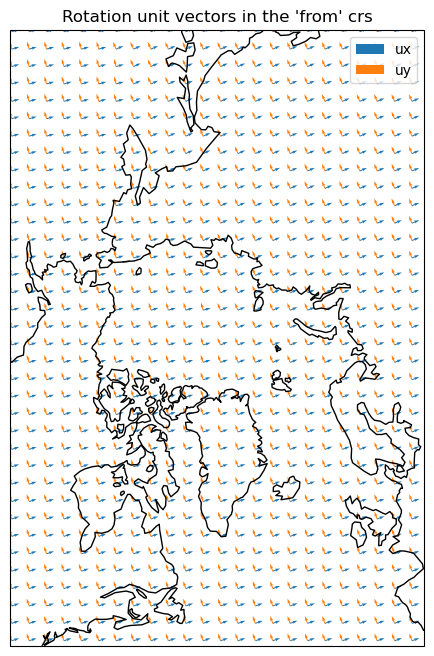

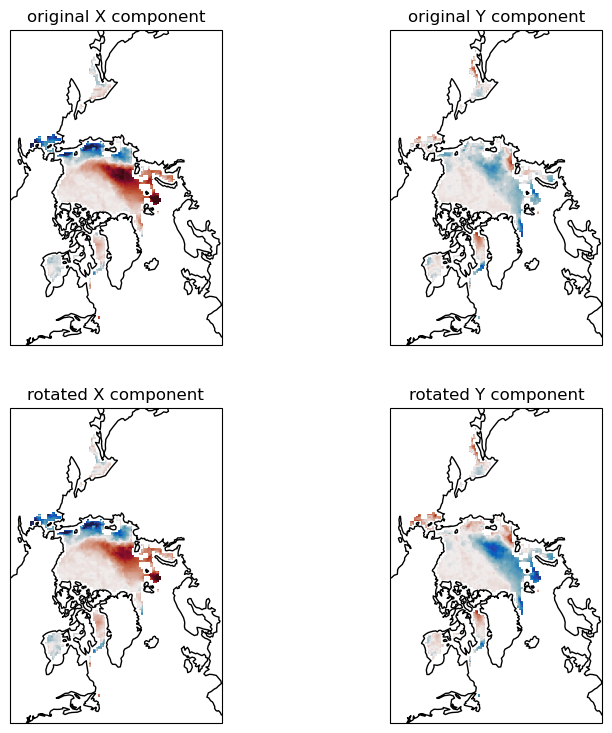

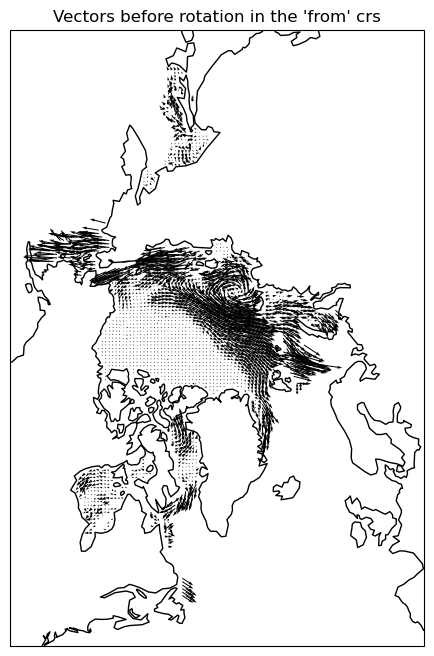

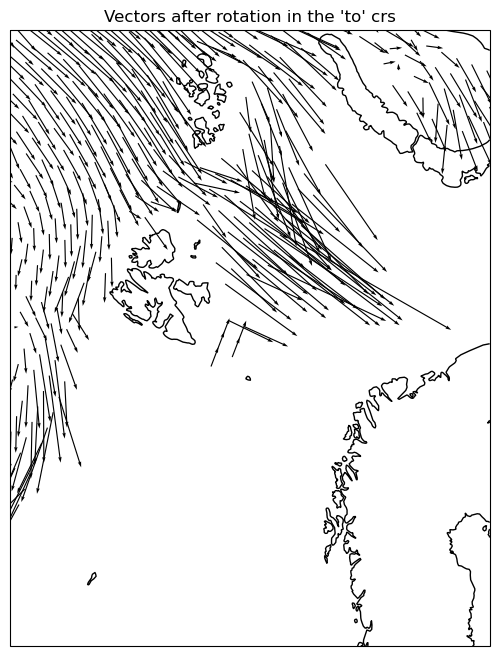

In [6]:
# Take an OSI SAF sea-ice drift Near Real Time file
f = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/drift_lr/merged/2020/03/ice_drift_nh_polstere-625_multi-oi_202003021200-202003041200.nc'
ds = xr.open_dataset(f)
adef, _ = pr.utils.load_cf_area(ds)
crs_from = adef.crs
x_from, y_from = np.meshgrid(adef.projection_x_coords, adef.projection_y_coords)
ccrs_from = adef.to_cartopy_crs()
vec_x = ds['dX'][0].data * 1000.
vec_y = ds['dY'][0].data * 1000.

# Define the target crs, that of a regional ocean/ice model of the Barents sea
f2 = 'https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_surface/2023/09/01/T00Z/barents_sfc_20230901T00Zm00.nc'
adef2, _ = pr.utils.load_cf_area(f2)
crs_to = adef2.crs
ccrs_to = adef2.to_cartopy_crs()

# rotate vector components
ux, uy = get_rotation_unit_vectors(x_from, y_from, crs_from, crs_to)
rot_x, rot_y = apply_vector_rotation(vec_x, vec_y, ux, uy)

# plot
plot_rotation_unit_vectors(x_from, y_from, ux, uy, ccrs_from, ccrs_to)
plot_vector_components(vec_x, vec_y, rot_x, rot_y, ccrs_from)
plot_vectors(x_from, y_from, vec_x, vec_y, rot_x, rot_y, crs_from, crs_to, ccrs_from, ccrs_to, ev=1)